## 0 - import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Standardisation
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Undersampling
from imblearn.under_sampling import RandomUnderSampler

# Réduction de dimension
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Evaluation des modèles
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Divers
from utils import dataframe_info, racine_projet

In [3]:
df = pd.read_csv(racine_projet()+'/data/processed/ML_data.csv', low_memory = False)

## 1 - filtres rajoutés/optionnels

In [4]:
#df= df[df['ResponseDuration'] >= 1]

In [5]:
df = df.drop(columns = ["DeployedFromStation_Name"])

## 2 - encodage

In [6]:
df_encoded = df.copy()

In [7]:
# Encodage binaire : DeployedFromLocation
encoder = LabelEncoder()
df_encoded['DeployedFromLocation'] = encoder.fit_transform(df_encoded['DeployedFromLocation'])

In [8]:
# Encodage getdummies : "PlusCode_Description", "PropertyCategory","AddressQualifier","IncidentType"
cols_to_encode = cols_to_encode = df_encoded.select_dtypes(include=['object']).columns 
df_encoded = pd.get_dummies(df_encoded, columns=cols_to_encode)

## 3 - train_test_split

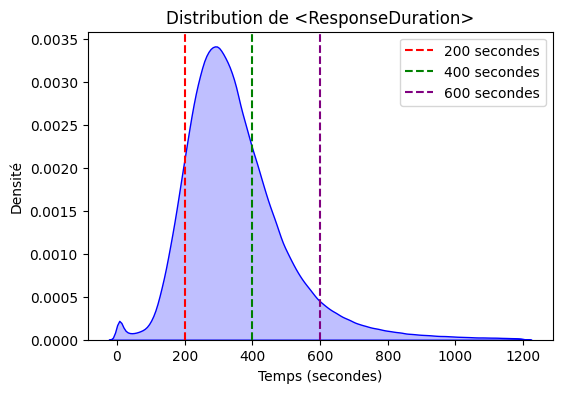

In [9]:
plt.figure(figsize=(6, 4))
sns.kdeplot(df_encoded['ResponseDuration'], fill = True, color='blue')

plt.axvline(x=200, color='red', linestyle='--', label='200 secondes')
plt.axvline(x=400, color='green', linestyle='--', label='400 secondes')
plt.axvline(x=600, color='purple', linestyle='--', label='600 secondes')

plt.title('Distribution de <ResponseDuration>')
plt.xlabel('Temps (secondes)')
plt.ylabel('Densité')
plt.legend(loc='upper right');

plt.savefig(racine_projet()+'/reports/figures/cat_distrib_arb.png')

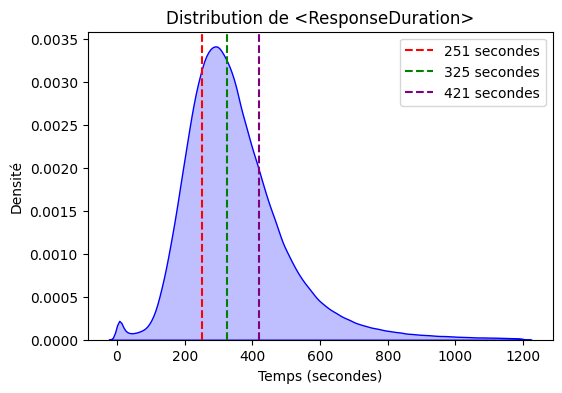

In [10]:
plt.figure(figsize=(6, 4))
sns.kdeplot(df_encoded['ResponseDuration'], fill = True, color='blue')

plt.axvline(x=251, color='red', linestyle='--', label='251 secondes')
plt.axvline(x=325, color='green', linestyle='--', label='325 secondes')
plt.axvline(x=421, color='purple', linestyle='--', label='421 secondes')

plt.title('Distribution de <ResponseDuration>')
plt.xlabel('Temps (secondes)')
plt.ylabel('Densité')
plt.legend(loc='upper right');

plt.savefig(racine_projet()+'/reports/figures/cat_distrib_norm.png')


In [9]:
bins = [df_encoded['ResponseDuration'].min(), 251, 325, 421, df_encoded['ResponseDuration'].max()]
labels = [0,1,2,3]

df_encoded['ResponseCat'] = pd.cut(df_encoded.ResponseDuration, bins=bins, labels= labels, include_lowest=True)


In [10]:
target = df_encoded['ResponseCat']
df_encoded = df_encoded.drop(columns = ['ResponseDuration'])

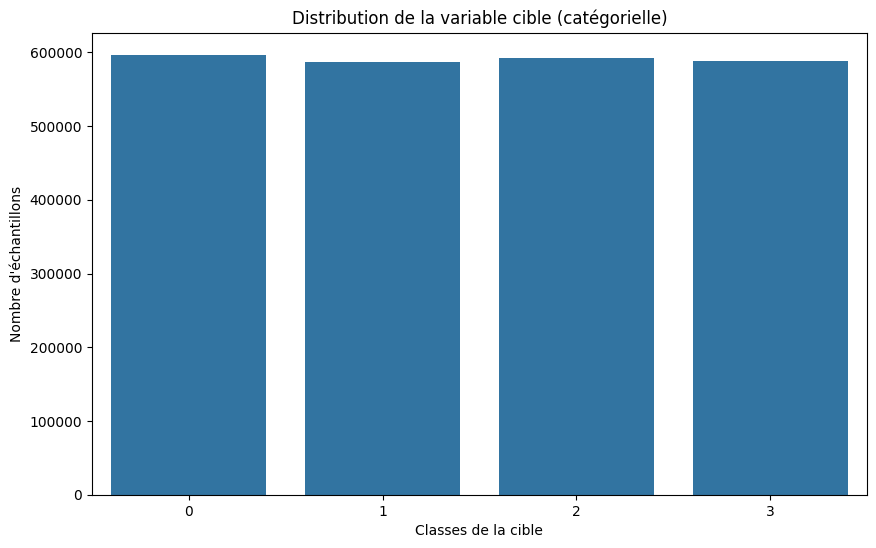

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x=target)
plt.title('Distribution de la variable cible (catégorielle)')
plt.xlabel('Classes de la cible')
plt.ylabel('Nombre d\'échantillons')
plt.show()

In [12]:
X = df_encoded.drop(labels = ["ResponseCat"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,target, test_size=0.2, random_state=42)

### Undersampling

In [13]:
sampling_strategy = {0: 50000, 1: 50000, 2: 50000, 3: 50000}

rus = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % y_train_resampled.shape)

Resampled dataset shape 200000


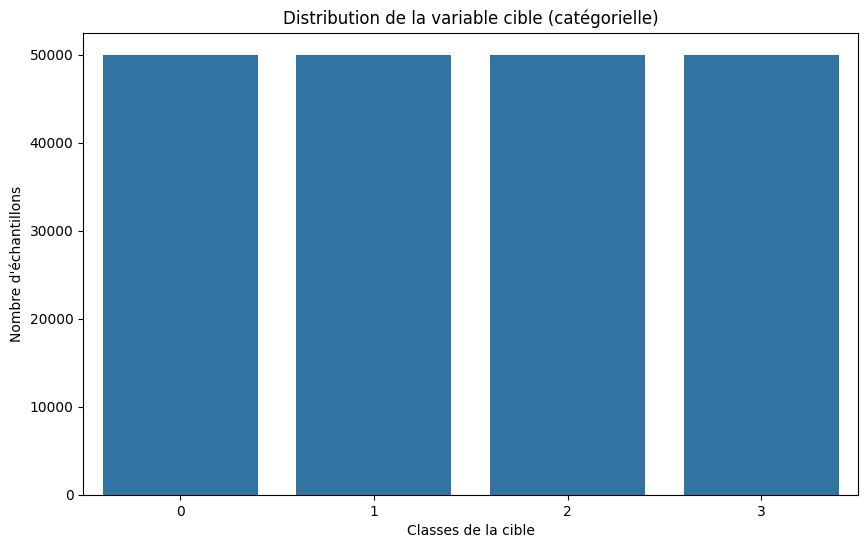

In [14]:
# Affichage de la distribution de la target catégorisée
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_resampled)
plt.title('Distribution de la variable cible (catégorielle)')
plt.xlabel('Classes de la cible')
plt.ylabel('Nombre d\'échantillons')
plt.show()

## 4 - normalisation (Standard or Minmax)

In [15]:
X_train = X_train_resampled
y_train = y_train_resampled

In [16]:
# Standard OU minmax
# "Northing_rounded","Easting_rounded", "PumpOrder", "NumStationsWithPumpsAttending", "NumPumpsAttending", "NumCalls", "year"
columns_for_scaling = ["Northing_rounded",
                       "Easting_rounded",
                       "PumpOrder",
                       "NumStationsWithPumpsAttending",
                       "NumPumpsAttending",
                       "NumCalls",
                       "year",
                       "rain", # rajoutée
                       "temperature_2m",  # rajoutée
                       "relative_humidity_2m", # rajoutée
                       "weather_code", # rajoutée
                       "wind_speed_10m", # rajoutée
                       "wind_gusts_10m"] # rajoutée
scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train[columns_for_scaling]= scaler.fit_transform(X_train[columns_for_scaling])
X_test[columns_for_scaling] = scaler.transform(X_test[columns_for_scaling])


In [17]:
dataframe_info(pd.DataFrame(X_train))

,Column,Non-Null Count,NaN Count,NaN Percentage,Dtype,Example Value
0,DeployedFromLocation,200000,0,0.0,int64,0
1,PumpOrder,200000,0,0.0,float64,-0.595599
2,Easting_rounded,200000,0,0.0,float64,-1.887522
3,Northing_rounded,200000,0,0.0,float64,1.175974
4,NumStationsWithPumpsAttending,200000,0,0.0,float64,0.349341
...,...,...,...,...,...,...
67,IncidentType_Spills and Leaks (not RTC),200000,0,0.0,bool,False
68,IncidentType_Stand By,200000,0,0.0,bool,False
69,IncidentType_Suicide/attempts,200000,0,0.0,bool,False
70,IncidentType_Use of Special Operations Room,200000,0,0.0,bool,False


## 5 - réduction de dimension

## 6 - machine learning

### KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
cl_rep = classification_report(y_test, y_pred_knn)
cm = confusion_matrix(y_test, y_pred_knn)

print("Accuracy:", accuracy)
print(cl_rep)
print("\nConfusion Matrix:")
print(cm)

Accuracy: 0.33918080404837914
              precision    recall  f1-score   support

           0       0.35      0.51      0.42    119701
           1       0.28      0.30      0.29    117113
           2       0.30      0.24      0.27    118583
           3       0.48      0.30      0.37    117286

    accuracy                           0.34    472683
   macro avg       0.35      0.34      0.33    472683
weighted avg       0.35      0.34      0.33    472683


Confusion Matrix:
[[61066 33884 16607  8144]
 [48631 35648 21439 11395]
 [37905 33090 28617 18971]
 [26421 26134 29737 34994]]


### Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_dt)
cl_rep = classification_report(y_test, y_pred_dt)
cm = confusion_matrix(y_test, y_pred_dt)

print("Accuracy:", accuracy)
print(cl_rep)
print("\nConfusion Matrix:")
print(cm)

Accuracy: 0.3900076795653747
              precision    recall  f1-score   support

           0       0.48      0.47      0.48    119701
           1       0.32      0.33      0.32    117113
           2       0.32      0.33      0.32    118583
           3       0.44      0.43      0.43    117286

    accuracy                           0.39    472683
   macro avg       0.39      0.39      0.39    472683
weighted avg       0.39      0.39      0.39    472683


Confusion Matrix:
[[56507 31186 18263 13745]
 [29620 38449 29326 19718]
 [17693 29895 38669 32326]
 [13116 20277 33168 50725]]


### Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
cl_rep = classification_report(y_test, y_pred_rf)
cm = confusion_matrix(y_test, y_pred_rf)

print("Accuracy:", accuracy)
print(cl_rep)
print("\nConfusion Matrix:")
print(cm)

Accuracy: 0.41159720150714113
              precision    recall  f1-score   support

           0       0.43      0.60      0.50    119701
           1       0.32      0.28      0.30    117113
           2       0.34      0.25      0.29    118583
           3       0.52      0.52      0.52    117286

    accuracy                           0.41    472683
   macro avg       0.40      0.41      0.40    472683
weighted avg       0.40      0.41      0.40    472683


Confusion Matrix:
[[71549 26925 12798  8429]
 [46741 32543 22126 15703]
 [30624 25376 29779 32804]
 [18786 15717 22099 60684]]


### XGB

In [21]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=100,  # Nombre d'arbres à construire
    max_depth=3,        # Profondeur maximale de chaque arbre
    learning_rate=0.1,  # Taux d'apprentissage
    random_state=42     # Seed pour la reproductibilité
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
cl_rep = classification_report(y_test, y_pred_xgb)
cm = confusion_matrix(y_test, y_pred_xgb)

print("Accuracy:", accuracy)
print(cl_rep)
print("\nConfusion Matrix:")
print(cm)

Accuracy: 0.41194204149504
              precision    recall  f1-score   support

           0       0.40      0.72      0.52    119701
           1       0.33      0.17      0.22    117113
           2       0.35      0.22      0.27    118583
           3       0.51      0.54      0.52    117286

    accuracy                           0.41    472683
   macro avg       0.40      0.41      0.38    472683
weighted avg       0.40      0.41      0.38    472683


Confusion Matrix:
[[86212 14063 10233  9193]
 [60778 19405 20341 16589]
 [41170 16315 26094 35004]
 [26171  9802 18306 63007]]


#### Interprétation

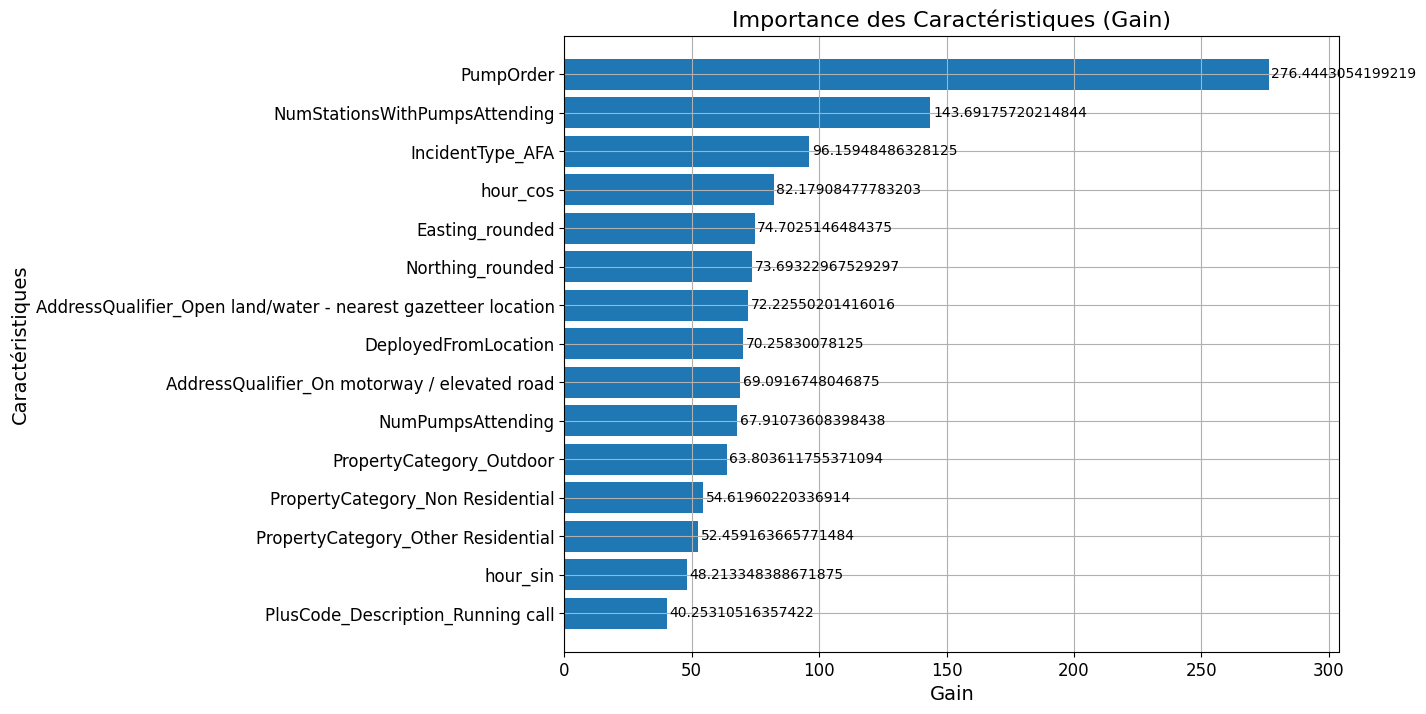

In [22]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 8))  # Augmenter la taille du graphique
plot_importance(xgb, importance_type='gain', ax=ax, max_num_features=15, height=0.8)  # Ajuster la hauteur des barres et limiter le nombre de caractéristiques

# Ajouter un titre et ajuster la taille des étiquettes
plt.title('Importance des Caractéristiques (Gain)', fontsize=16)
plt.xlabel('Gain', fontsize=14)
plt.ylabel('Caractéristiques', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [23]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   class_names=['0', '1', '2', '3'], 
                                                   discretize_continuous=True)
instance_to_explain = X_test.iloc[0].values
exp = explainer.explain_instance(instance_to_explain, xgb.predict_proba, num_features=74)

exp.show_in_notebook(show_table=True)

### Random Forest gridsearch

In [33]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END bootstrap=True, max_depth=None, min_samples_split=2, n_estimators=50; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, min_samples_split=2, n_estimators=100; total time= 4.5min
[CV] END bootstrap=True, max_depth=None, min_samples_split=5, n_estimators=50; total time= 2.5min
[CV] END bootstrap=True, max_depth=None, min_samples_split=5, n_estimators=100; total time= 6.5min
[CV] END bootstrap=True, max_depth=None, min_samples_split=5, n_estimators=200; total time= 8.9min
[CV] END bootstrap=True, max_depth=None, min_samples_split=10, n_estimators=200; total time= 7.1min
[CV] END bootstrap=True, max_depth=10, min_samples_split=2, n_estimators=200; total time= 2.5min
[CV] END bootstrap=True, max_depth=10, min_samples_split=5, n_estimators=200; total time= 2.5min
[CV] END bootstrap=True, max_depth=10, min_samples_split=10, n_estimators=200; total time= 2.6min
[CV] END bootstrap=True, max_depth=20, min_samples_sp

In [34]:
best_rf = grid_search.best_estimator_
y_pred_RFgs = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_RFgs)
cl_rep = classification_report(y_test, y_pred_RFgs)
cm = confusion_matrix(y_test, y_pred_RFgs)

print("Accuracy:", accuracy)
print(cl_rep)
print("\nConfusion Matrix:")
print(cm)

[CV] END bootstrap=True, max_depth=None, min_samples_split=2, n_estimators=50; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, min_samples_split=2, n_estimators=100; total time= 4.5min
[CV] END bootstrap=True, max_depth=None, min_samples_split=5, n_estimators=50; total time= 2.5min
[CV] END bootstrap=True, max_depth=None, min_samples_split=5, n_estimators=100; total time= 6.5min
[CV] END bootstrap=True, max_depth=None, min_samples_split=5, n_estimators=200; total time= 8.9min
[CV] END bootstrap=True, max_depth=None, min_samples_split=10, n_estimators=200; total time= 7.1min
[CV] END bootstrap=True, max_depth=10, min_samples_split=2, n_estimators=200; total time= 2.5min
[CV] END bootstrap=True, max_depth=10, min_samples_split=5, n_estimators=200; total time= 2.6min
[CV] END bootstrap=True, max_depth=10, min_samples_split=10, n_estimators=200; total time= 2.6min
[CV] END bootstrap=True, max_depth=20, min_samples_split=2, n_estimators=100; total time= 2.7min
[CV] END bootstrap

### XG Boost Gridsearch

In [21]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)

#  grille de paramètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],        # Nombre d'arbres
    'max_depth': [3, 4, 5, 6],             # Profondeur maximale des arbres
    'learning_rate': [0.01, 0.1, 0.2],     # Taux d'apprentissage
    'subsample': [0.8, 1.0],               # Fraction de l'échantillon à utiliser pour l'entraînement de chaque arbre
    'colsample_bytree': [0.8, 1.0],        # Fraction des colonnes à utiliser pour l'entraînement de chaque arbre
    'gamma': [0, 0.1, 0.2]                 # Régularisation par complexité de modèle
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

# Entraîner le modèle avec les meilleurs paramètres trouvés & prédire les valeurs de test
best_xgb = grid_search.best_estimator_
y_pred_xgb_gs = best_xgb.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred_xgb_gs)
cl_rep = classification_report(y_test, y_pred_xgb_gs)
cm = confusion_matrix(y_test, y_pred_xgb_gs)

print("Accuracy:", accuracy)
print(cl_rep)
print("\nConfusion Matrix:")
print(cm)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Meilleurs paramètres trouvés :  {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.4841
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.74      0.61    119701
           1       0.40      0.33      0.36    117113
           2       0.41      0.33      0.37    118583
           3       0.56      0.54      0.55    117286

    accuracy                           0.48    472683
   macro avg       0.47      0.48      0.47    472683
weighted avg       0.47      0.48      0.47    472683



In [22]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


Confusion Matrix:
[[88001 18700  7387  5613]
 [42303 38387 23934 12489]
 [21989 26677 39484 30433]
 [15403 13110 25803 62970]]


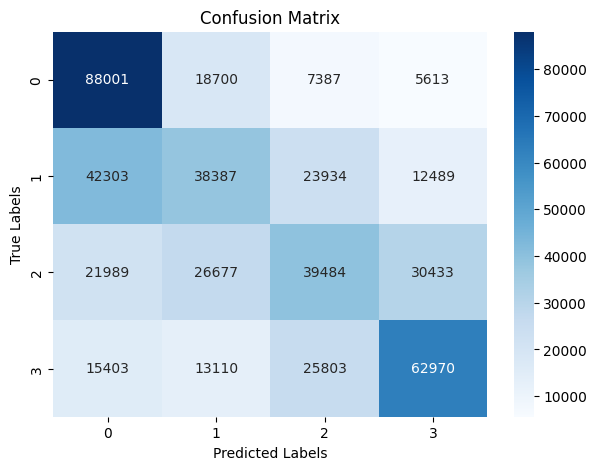

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Interprétation

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   class_names=['0', '1', '2', '3'], 
                                                   discretize_continuous=True)
instance_to_explain = X_test.iloc[0].values
exp = explainer.explain_instance(instance_to_explain, best_xgb.predict_proba, num_features=74)

exp.show_in_notebook(show_table=True)